In [5]:
!cp /content/drive/MyDrive/Colab\ Notebooks/model_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/train.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/predict_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/vis_utils.py /content

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import model_utils

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [9]:
use_gpu

True

In [10]:
!nvidia-smi

Sat Jan 21 08:27:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
DATA_DIR = '/content/drive/MyDrive/catvsdog/PetImages/'
sz = 224
batch_size = 20

In [12]:
os.listdir(DATA_DIR)

['train', 'valid']

In [13]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [14]:
os.listdir(trn_dir)

['Cat', 'Dog']

In [15]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['/content/drive/MyDrive/catvsdog/PetImages/train/Cat/7953.jpg',
 '/content/drive/MyDrive/catvsdog/PetImages/train/Cat/7975.jpg',
 '/content/drive/MyDrive/catvsdog/PetImages/train/Cat/7960.jpg',
 '/content/drive/MyDrive/catvsdog/PetImages/train/Cat/7959.jpg',
 '/content/drive/MyDrive/catvsdog/PetImages/train/Cat/7961.jpg']

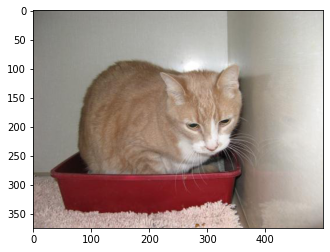

In [16]:
img = plt.imread(trn_fnames[1])
plt.imshow(img);

In [17]:
train_ds = datasets.ImageFolder(trn_dir)

In [18]:
train_ds.classes


['Cat', 'Dog']

In [19]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [20]:
# len(train_ds)
len(train_ds)


17678

In [21]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=8)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


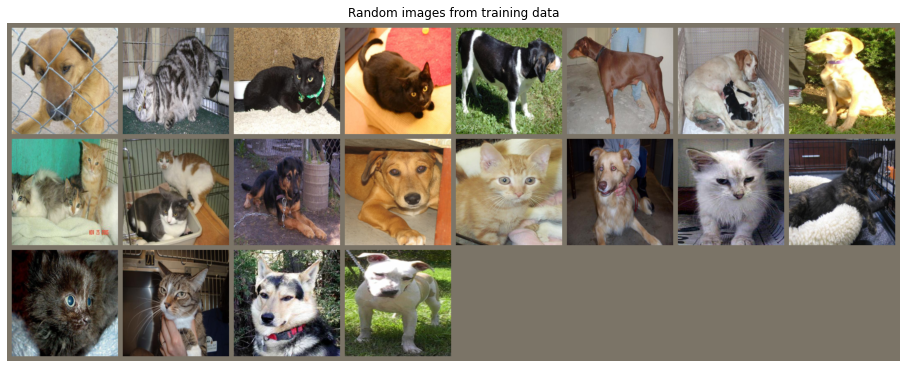

In [22]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=10)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')


In [23]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128 , 264, kernel_size=5, padding=2),
            nn.BatchNorm2d(264),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(264, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, padding=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(1 * 1 * 1024, 512)
        self.fc1 = nn.Linear(512 ,256)
        self.fc2 = nn.Linear(256,128 )
        self.fc3 = nn.Linear(128, 2)
        # self.fc = nn.Linear(7 * 7 * 256 , 10)
        # self.fc1 = nn.Linear(10, 2)
      

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out =self.conv3(out)
        out= self.conv4(out)
        out =self.conv5(out)
        out =self.conv6(out)
        out =self.conv7(out)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = F.relu(self.fc(out))
        out= F.relu(self.fc1(out))
        out =F.relu(self.fc2(out))

        out = self.fc3(out)
        # out =self.fc1(out)
        return out


In [24]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


In [26]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))


Epoch [ 1/ 5], Step [ 50/883], Loss: 0.7470
Epoch [ 1/ 5], Step [100/883], Loss: 0.7735
Epoch [ 1/ 5], Step [150/883], Loss: 0.6131
Epoch [ 1/ 5], Step [200/883], Loss: 0.6765
Epoch [ 1/ 5], Step [250/883], Loss: 0.6872
Epoch [ 1/ 5], Step [300/883], Loss: 0.3218
Epoch [ 1/ 5], Step [350/883], Loss: 0.4516
Epoch [ 1/ 5], Step [400/883], Loss: 0.3932
Epoch [ 1/ 5], Step [450/883], Loss: 0.6805
Epoch [ 1/ 5], Step [500/883], Loss: 0.2938
Epoch [ 1/ 5], Step [550/883], Loss: 0.6291
Epoch [ 1/ 5], Step [600/883], Loss: 0.6715
Epoch [ 1/ 5], Step [650/883], Loss: 0.3843
Epoch [ 1/ 5], Step [700/883], Loss: 0.6164
Epoch [ 1/ 5], Step [750/883], Loss: 0.5082
Epoch [ 1/ 5], Step [800/883], Loss: 0.3916
Epoch [ 1/ 5], Step [850/883], Loss: 0.4306
Epoch [ 2/ 5], Step [ 50/883], Loss: 0.4006
Epoch [ 2/ 5], Step [100/883], Loss: 0.4523
Epoch [ 2/ 5], Step [150/883], Loss: 0.4031
Epoch [ 2/ 5], Step [200/883], Loss: 0.3958
Epoch [ 2/ 5], Step [250/883], Loss: 0.2725
Epoch [ 2/ 5], Step [300/883], L

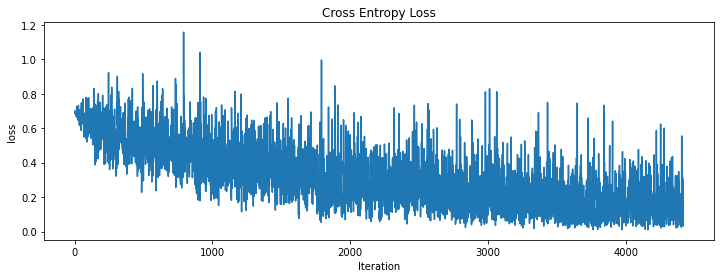

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [28]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    

In [29]:
evaluate_model(model, valid_dl, device)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

accuracy: 88.04


In [30]:
evaluate_model(model, train_dl, device)


accuracy: 94.83


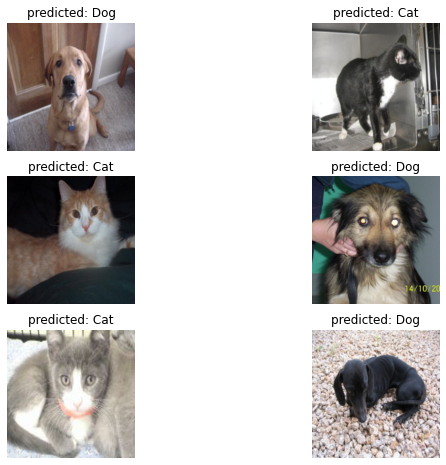

In [31]:
visualize_model(model, train_dl, device)


 85%|████████▍ | 312/368 [00:32<00:05, 10.05it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/

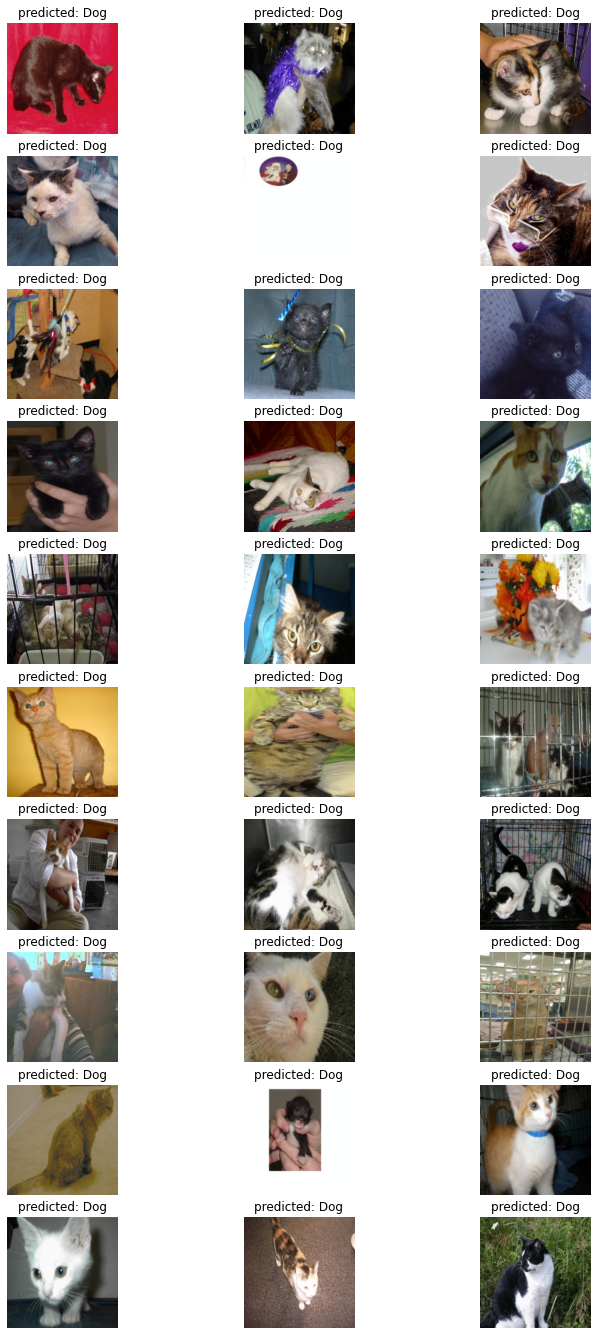

337 images out of 7355 were misclassified.


In [32]:
plot_errors(model, valid_dl, device)
